In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv


Gerekli kütüphaneleri import ettim

In [10]:
df = pd.read_csv('/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv')

Pandas ile csv verisini okudum

In [11]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


Dataseti hakkında genel bilgiye sahip olmak için üstteki kod satırlarını kullandım

In [13]:
df.drop(['neo_id','name','orbiting_body'], axis=1, inplace=True)
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,False
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,True
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,False
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,False
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,False


İhtiyacım olmayan ve veri tipinde fazlalık olan sütunları kaldırdım

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338171 non-null  float64
 1   estimated_diameter_min  338171 non-null  float64
 2   estimated_diameter_max  338171 non-null  float64
 3   relative_velocity       338199 non-null  float64
 4   miss_distance           338199 non-null  float64
 5   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 13.2 MB


Kalan verilerim float ve bool tipinde


In [15]:
df['is_hazardous'] = df['is_hazardous'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338171 non-null  float64
 1   estimated_diameter_min  338171 non-null  float64
 2   estimated_diameter_max  338171 non-null  float64
 3   relative_velocity       338199 non-null  float64
 4   miss_distance           338199 non-null  float64
 5   is_hazardous            338199 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 15.5 MB


Bool tipindeki veriyi int e çeviriyorum ve böylece algoritmam rahatlıkla çalışabilir


<Axes: title={'center': 'Hazardous Distribution Plot'}, xlabel='is_hazardous', ylabel='Density'>

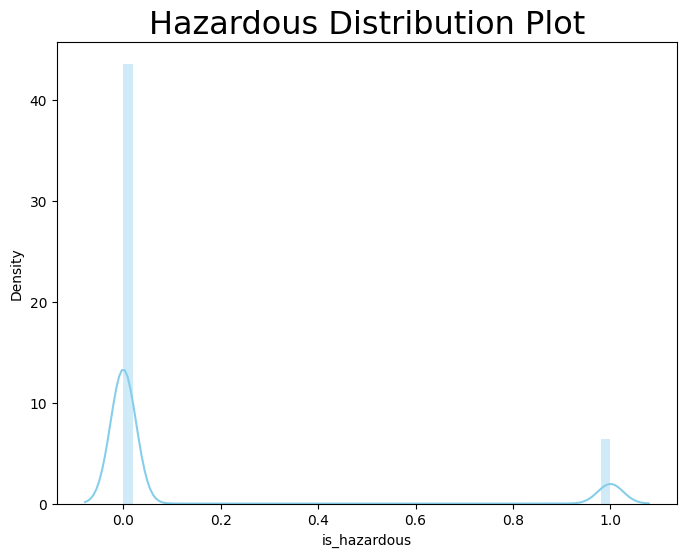

In [16]:
f0, ax = plt.subplots(figsize=(8, 6))
plt.title('Hazardous Distribution Plot',fontsize=23)
sns.distplot(df['is_hazardous'], color='skyblue')

Tehlikeli cisim dağılım grafiği

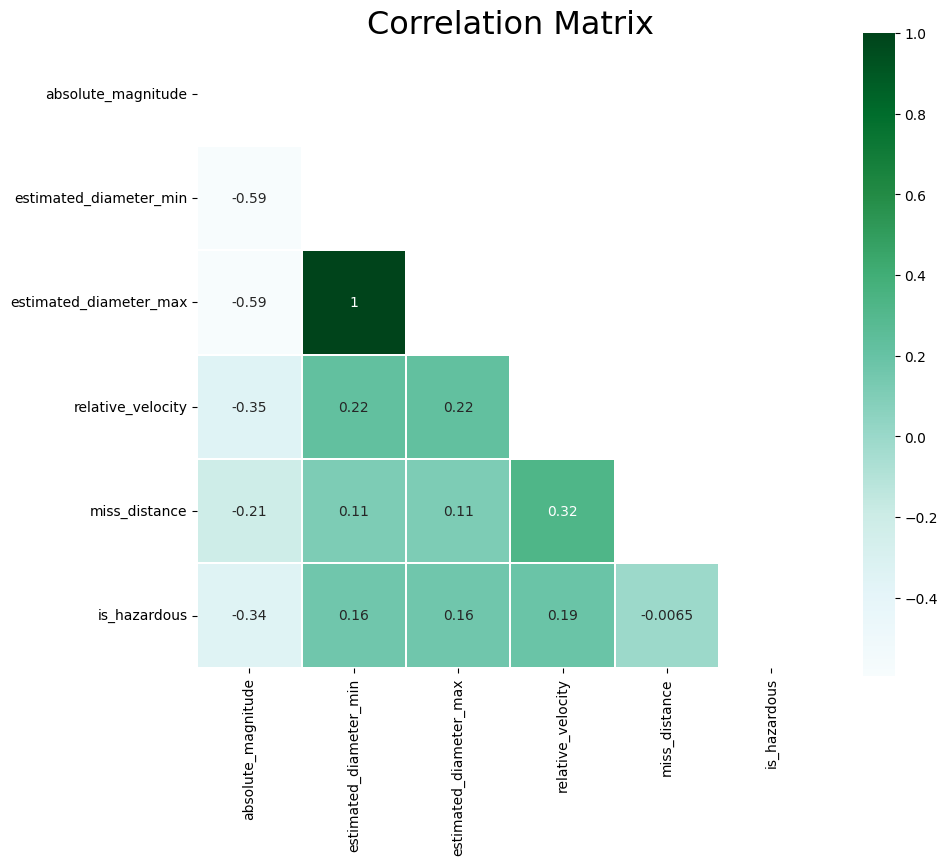

In [17]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))
plt.title('Correlation Matrix',fontsize=23)

sns.heatmap(df.corr(),linewidths=0.25, vmax=1.0, square=True, cmap="BuGn",
            linecolor='w', annot=True, mask=mask, cbar_kws={"shrink": .75})
f.tight_layout()

Korelasyon matrisi çizip hangi veri sütunlarının pozitif ve negatif korelasyona sahip olduğunu anlıyorum

Text(0.5, 0.98, 'Positive and Negative Correlation Visualizations')

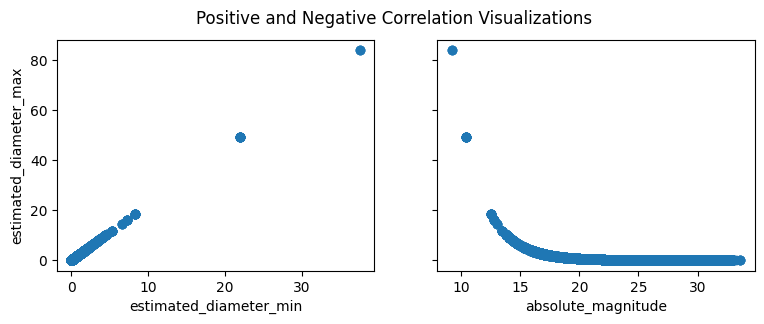

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].scatter(df["estimated_diameter_min"].values, df["estimated_diameter_max"].values)
axs[0].set_xlabel('estimated_diameter_min')
axs[0].set_ylabel('estimated_diameter_max')
axs[1].scatter(df["absolute_magnitude"].values, df["estimated_diameter_max"].values)
axs[1].set_xlabel('absolute_magnitude')
fig.suptitle('Positive and Negative Correlation Visualizations')

Korelasyon matrisinin pozitif ve negatif değerlerini grafikte çizdiriyorum

In [19]:
df.isnull().any()

absolute_magnitude         True
estimated_diameter_min     True
estimated_diameter_max     True
relative_velocity         False
miss_distance             False
is_hazardous              False
dtype: bool

Veri setimde NaN değerler var mı kontrol ediyorum

In [20]:
imputer = SimpleImputer(strategy='mean')

NaN değerleri Simple Imputer algoritmasının ortalama ('mean') metodu ile dolduruyorum

In [21]:
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [22]:
df.isnull().any()

absolute_magnitude        False
estimated_diameter_min    False
estimated_diameter_max    False
relative_velocity         False
miss_distance             False
is_hazardous              False
dtype: bool

NaN değerlerin tamamını doldurmuş oldum

In [23]:
scaler = StandardScaler()
df_dropped = df.drop('is_hazardous', axis=1)
X = df_dropped.values[:, 1:]
scaled_x = scaler.fit_transform(X)

Verileri Scale ediyorum 

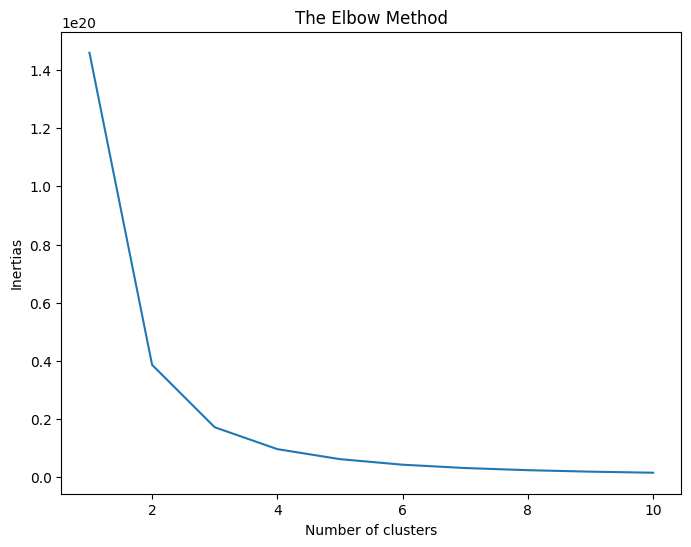

In [24]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,11),inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

Elbow Metodunu kullanarak Küme sayısının 3 olması gerektiğini buluyorum

In [25]:
model = KMeans(n_clusters=3,init='k-means++',max_iter=300, n_init=12, random_state=0)
model.fit(scaled_x)
labels = model.predict(scaled_x)

Küme sayısını belirletip Scale edilmiş verileri modelimle işliyorum

In [26]:
X.shape

(338199, 4)

In [27]:
labels.shape

(338199,)

X ve labels değişkenlerinin veri sayılarını kontrol ediyorum. Eğer veri sayıları farklıysa Silhouette hesaplaması çalışmıyor

In [28]:
silhouette_avg = silhouette_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)

print("Silhouette score:", silhouette_avg)
print("Calinski-Harabasz index:", calinski_harabasz)

Silhouette score: 0.26105765104317713
Calinski-Harabasz index: 228572.22776486326


n cluster = 2

Silhouette score: 0.25664688040390204 Calinski-Harabasz index: 168075.50803760331

n cluster = 3

Silhouette score: 0.2611648992717095 Calinski-Harabasz index: 228779.3895567206

n cluster = 4

Silhouette score: 0.2600648318860417 Calinski-Harabasz index: 156374.08532752574

n_clusters = 3 değerinde en iyi skoru ve indeksi alıyor.

0.5'ten büyük: Genellikle iyi bir kümeleme olduğunu gösterir. Veri noktaları kendi kümeleri içinde yoğunlaşmış ve diğer kümelerden iyi ayrılmıştır. 0 ile 0.5 arasında: Kümeleme sonuçları orta düzeydedir. Bazı veri noktaları doğru kümede olmayabilir veya küme sınırları belirsiz olabilir. 0'a yakın veya negatif: Kümeleme başarısız olmuş olabilir. Veri noktaları doğru kümelere atanmamış veya kümeler iyi tanımlanmamıştır. Bu durumda: 0.26 gibi bir skor, kümelemenin orta düzeyde olduğunu gösterir. Veri noktalarının bir kısmı doğru kümelere atanmış olabilir, ancak bazı belirsizlikler de olabilir.

Bu durumda: 228779 gibi yüksek bir değer, kümeler arasında iyi bir ayrım olduğunu gösterir. Ancak, bu skor tek başına yeterli değildir. Silhouette skoru ile birlikte değerlendirilmelidir.

Genel Değerlendirme Orta Düzeyde Kümeleme: Hem Silhouette skoru hem de Calinski-Harabasz indeksi, kümelemenin orta düzeyde olduğunu gösteriyor.

